## Embeddings in graphs


Here, we will use the Karate Club graph to demonstrate how to generate node embeddings using the Node2Vec algorithm and how to use these embeddings to generate edge embeddings. 


-    Data Source: The study was conducted by Wayne Zachary, an American sociologist, in 1977.
-    The Club: Zachary studied a university karate club for about two years (1970-1972).
-    The Conflict: During the study period, a conflict arose between the club's administrator (referred to as "John A.") and the chief instructor ("Mr. Hi").
-    The Split: This conflict led to a split in the club, with some members leaving with the instructor to form a new club, while others stayed with the administrator.
-    The Data: Zachary documented the social connections between 34 club members before the split.
-    The Objective: The goal was to try to predict which members would stay in the original club and who would move to the new club, based on their social connections.


In [1]:
import networkx as nx
import matplotlib.pylab as plt
import numpy as np
tab10 = plt.get_cmap('tab10')
%matplotlib inline

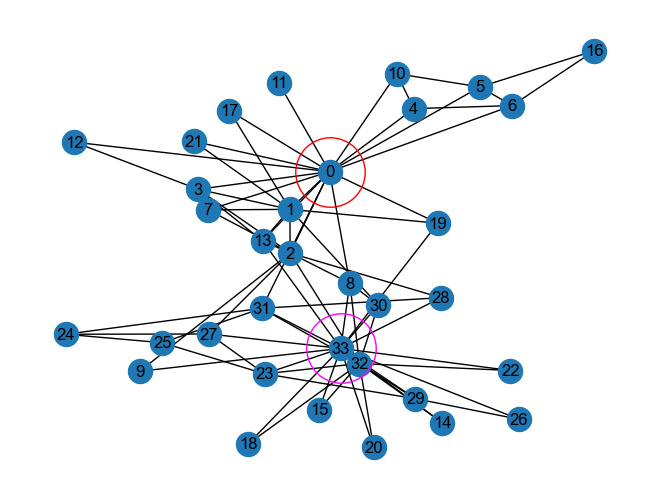

In [13]:
G_karate = nx.karate_club_graph()
communities = nx.community.greedy_modularity_communities(G_karate, weight='weight', resolution=1)
# color nodes by community
node_colors = dict()
for i, c in enumerate(communities):
    for n in c:
        node_colors[n] = tab10(i)
node_colors = [node_colors[n] for n in G_karate.nodes()]
node_labels = {n:n  for n, data in G_karate.nodes(data=True)}
pos = nx.spring_layout(G_karate, weight='weight')
nx.draw(G_karate, with_labels=True, labels=node_labels, pos=pos)
pos_0 = pos[0]
pos_33 = pos[33]
plt.plot(pos_0[0], pos_0[1], 'o', mec='red', mfc='none', ms=50)
plt.plot(pos_33[0], pos_33[1], 'o', mec='magenta', mfc='none', ms=50)

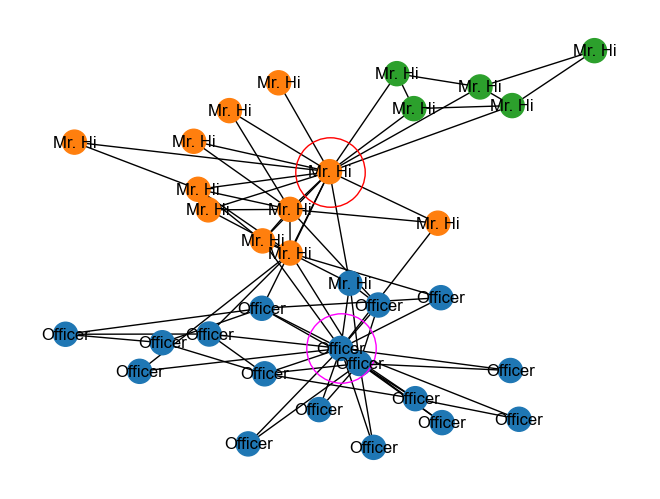

In [14]:
node_labels = {n:data['club'] for n, data in G_karate.nodes(data=True)}
nx.draw(G_karate, with_labels=True, labels=node_labels, node_color=node_colors, pos=pos)
plt.plot(pos_0[0], pos_0[1], 'o', mec='red', mfc='none', ms=50)
plt.plot(pos_33[0], pos_33[1], 'o', mec='magenta', mfc='none', ms=50)

In [15]:
# if the below fails, install
#  pip install node2vec
# If you still get an error, try installing scipy 1.12
#  pip install scipy==1.12
# and restart the kernel
from node2vec import Node2Vec

In [17]:
node2vec = Node2Vec(
    G_karate, 
    dimensions=8,  # The number of dimensions of the embeddings.
    # More dimensions can capture more information but may increase computational complexity.
    # Higher dimensions can also lead to overfitting, especially if the dataset is small.
    walk_length=150, # The length of each random walk.
    # Longer walks can capture more structural information from the graph, 
    # which can be beneficial for capturing distant relationships.
    num_walks=200,  # The number of random walks to perform from each node.
    # More walks can improve the quality of the embeddings by providing more context and variability.
    workers=4    # The number of worker threads to use for parallel processing.
    # More workers can speed up the computation, especially on multi-core machines.
)

# Fit the Node2Vec model to generate node embeddings.
model = node2vec.fit(
    window=128,     # The window size for the Word2Vec model. 
    # This parameter determines the context window size for the skip-gram model.
    # A larger window captures broader context, which can be useful for capturing relationships
    # between nodes that are further apart in the random walks.
    min_count=1,   # The minimum number of occurrences of a node to be included in the training.
    # Setting this to 1 ensures that all nodes are included in the model.
    batch_words=4  # The number of words to process in each batch. 
    # This parameter affects the speed of training and memory usage.
    # Smaller batch sizes can lead to slower training but may require less memory.
)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:00<00:00, 110.39it/s]


In [22]:
model.wv.get_vector('2')

array([ 0.38288197, -0.5119605 ,  0.01894676, -0.06937078,  0.11561461,
        0.16597009,  0.3486103 ,  0.06144436], dtype=float32)

In [23]:
node_vecs = model.wv.vectors

In [24]:
import pandas as pd
import seaborn as sns
node_node_distances = []
for i in range(len(node_vecs)):
    club_i = G_karate.nodes[i]['club']
    for j in range(i+1, len(node_vecs)):
        club_j = G_karate.nodes[j]['club']
        dist = (np.linalg.norm(node_vecs[i] - node_vecs[j]))
        within_same_club = club_i == club_j
        node_node_distances.append((i, j, dist, within_same_club))
node_node_distances = np.array(node_node_distances)
node_node_distances = pd.DataFrame(node_node_distances, columns=['node_i', 'node_j', 'distance', 'within_same_club'])

Text(0.5, 1.0, 'no apparent separation between nodes in the same club and different clubs')

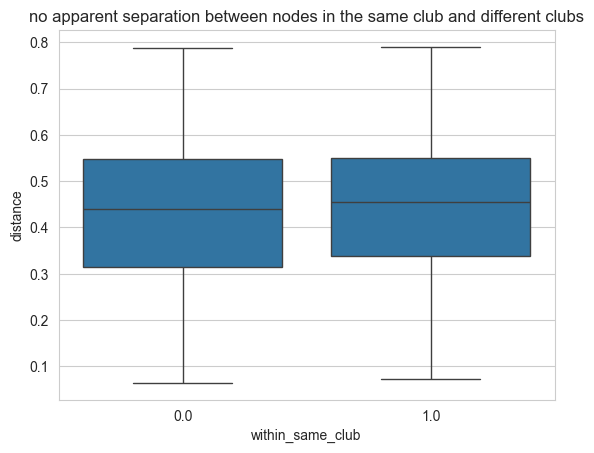

In [25]:
fig, ax = plt.subplots()
sns.boxplot(data=node_node_distances, x='within_same_club', y='distance')
ax.set_title('no apparent separation between nodes in the same club and different clubs')

Another way to visualize the embeddings is to use t-SNE to reduce the dimensionality of the embeddings to 2D and plot them.


Text(0.5, 1.0, 'Node embeddings in 2D - no clear separation between clubs')

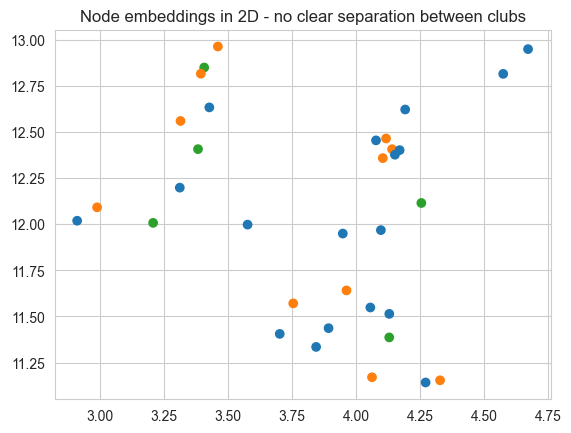

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_vecs)
fig, ax = plt.subplots()
ax.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colors)
ax.set_title('Node embeddings in 2D - no clear separation between clubs')

## Edge Embedding

In [27]:
from node2vec.edges import HadamardEmbedder
edges_embs = HadamardEmbedder(keyed_vectors=model.wv) # using node embeddings to generate edge embeddings

In [28]:
edges_embs[('1', '2')]

array([ 0.17742234,  0.24240313, -0.00064009,  0.00485592,  0.00821438,
        0.02180567,  0.15163161,  0.00430923], dtype=float32)

In [29]:
edges_kv = edges_embs.as_keyed_vectors()
edges_kv.most_similar(str(('1', '2')))

Generating edge features: 100%|██████████| 595/595.0 [00:00<00:00, 408179.73it/s]


[("('1', '13')", 0.9971860647201538),
 ("('0', '1')", 0.9971666932106018),
 ("('12', '17')", 0.9960258603096008),
 ("('13', '2')", 0.9955266714096069),
 ("('13', '13')", 0.9951050281524658),
 ("('17', '7')", 0.9950664639472961),
 ("('17', '3')", 0.9940235614776611),
 ("('1', '9')", 0.9929623603820801),
 ("('1', '8')", 0.9928872585296631),
 ("('1', '11')", 0.9918803572654724)]

In [30]:
edge_embeddings = []
edge_class = []
for u, v in G_karate.edges():
    club_u = G_karate.nodes[u]['club']
    club_v = G_karate.nodes[v]['club']
    within_same_club = club_u == club_v
    edge_embedding = edges_embs[(str(u), str(v))]
    edge_embeddings.append(edge_embedding)
    edge_class.append(within_same_club)
edge_embeddings = np.array(edge_embeddings)
edge_class = np.array(edge_class)

Text(0.5, 1.0, 'Edge embeddings in 2D\nvisible separation between edges within the same club and different clubs')

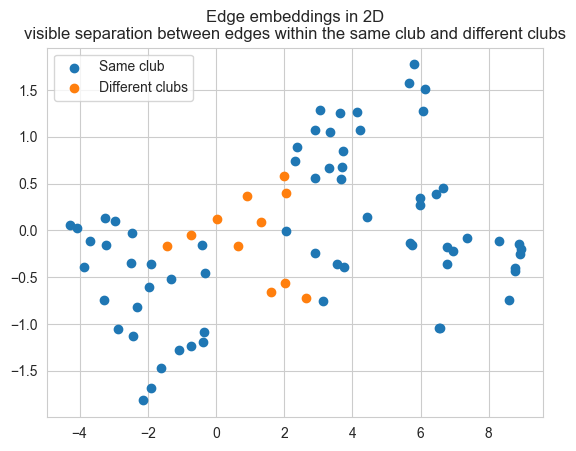

In [37]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
edge_embeddings_2d = tsne.fit_transform(edge_embeddings)
fig, ax = plt.subplots()
ax.scatter(edge_embeddings_2d[edge_class, 0], edge_embeddings_2d[edge_class, 1], c='C0', label='Same club')
ax.scatter(edge_embeddings_2d[~edge_class, 0], edge_embeddings_2d[~edge_class, 1], c='C1', label='Different clubs')
ax.legend()
ax.set_title('Edge embeddings in 2D\nvisible separation between edges within the same club and different clubs')

In [39]:
# 3d with plotly
import plotly.express as px
edge_embeddings_3d = TSNE(n_components=3).fit_transform(edge_embeddings)
edge_embeddings_3d = pd.DataFrame(edge_embeddings_3d, columns=['x', 'y', 'z'])
edge_embeddings_3d['within_same_club'] = edge_class
fig = px.scatter_3d(edge_embeddings_3d, x='x', y='y', z='z', color='within_same_club')
fig.show()

In [33]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(edge_embeddings, edge_class)

Learning rate set to 0.003466
0:	learn: 0.6897160	total: 55.9ms	remaining: 55.9s
1:	learn: 0.6864689	total: 56.4ms	remaining: 28.1s
2:	learn: 0.6829853	total: 56.8ms	remaining: 18.9s
3:	learn: 0.6797045	total: 57.2ms	remaining: 14.2s
4:	learn: 0.6764550	total: 57.6ms	remaining: 11.5s
5:	learn: 0.6727391	total: 58ms	remaining: 9.61s
6:	learn: 0.6693181	total: 58.6ms	remaining: 8.31s
7:	learn: 0.6661597	total: 59.2ms	remaining: 7.34s
8:	learn: 0.6630301	total: 60.4ms	remaining: 6.64s
9:	learn: 0.6596595	total: 60.9ms	remaining: 6.03s
10:	learn: 0.6559541	total: 61.3ms	remaining: 5.51s
11:	learn: 0.6524278	total: 61.7ms	remaining: 5.08s
12:	learn: 0.6491499	total: 62.1ms	remaining: 4.72s
13:	learn: 0.6460174	total: 62.6ms	remaining: 4.41s
14:	learn: 0.6418730	total: 63.4ms	remaining: 4.16s
15:	learn: 0.6388707	total: 63.9ms	remaining: 3.93s
16:	learn: 0.6358989	total: 64.4ms	remaining: 3.72s
17:	learn: 0.6319257	total: 64.8ms	remaining: 3.54s
18:	learn: 0.6280600	total: 65.2ms	remaining: 

In [34]:
from sklearn.metrics import classification_report
y_pred = model.predict(edge_embeddings)
print(classification_report(edge_class, y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00        11
        True       1.00      1.00      1.00        67

    accuracy                           1.00        78
   macro avg       1.00      1.00      1.00        78
weighted avg       1.00      1.00      1.00        78

